# 2. Federated Learning Training

**Project:** IoT Network Attack Detection using Federated Learning  
**Algorithm:** FedAvg (Federated Averaging)  
**Author:** Nguyen Duc Thang

---

## 📋 Objectives

1. Load preprocessed client data
2. Create global DNN model
3. Initialize Federated Server and Clients
4. Run FL training loop (30-50 rounds)
   - Server broadcasts model → Clients train locally → Server aggregates (FedAvg)
5. Save trained model and training history

---

## 🎯 Expected Outputs

- `../Output/models/global_model.h5`
- `../Output/metrics/training_history.json`

## 1. Setup and Imports

In [1]:
# Standard libraries
import os
import sys
import numpy as np
import json
import yaml
import matplotlib.pyplot as plt
from datetime import datetime

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras

# Import our utility modules
from utils import data_utils, model_utils, fl_utils

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {len(gpus)} device(s)")
    for gpu in gpus:
        print(f"   {gpu}")
else:
    print("⚠️  No GPU found. Training will use CPU (slower).")

print(f"\n✅ TensorFlow version: {tf.__version__}")
print(f"✅ Keras version: {keras.__version__}")

2025-12-28 14:09:58.768946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


⚠️  No GPU found. Training will use CPU (slower).

✅ TensorFlow version: 2.11.0
✅ Keras version: 2.11.0


## 2. Load Configuration

In [2]:
# Load training configuration
config_path = 'configs/training_config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("📄 Configuration loaded:")
print(f"\n🔧 FL Settings:")
print(f"   Number of clients: {config['num_clients']}")
print(f"   Number of rounds: {config['num_rounds']}")
print(f"   Local epochs: {config['local_epochs']}")
print(f"   Batch size: {config['batch_size']}")

print(f"\n🏗️  Model Architecture:")
print(f"   Input dim: {config['model']['input_dim']}")
print(f"   Hidden layers: {config['model']['hidden_layers']}")
print(f"   Output classes: {config['model']['num_classes']}")
print(f"   Dropout rate: {config['model']['dropout_rate']}")

print(f"\n⚙️  Optimizer:")
print(f"   Type: {config['optimizer']['type']}")
print(f"   Learning rate: {config['optimizer']['learning_rate']}")

📄 Configuration loaded:

🔧 FL Settings:
   Number of clients: 5
   Number of rounds: 10
   Local epochs: 5
   Batch size: 256

🏗️  Model Architecture:
   Input dim: 46
   Hidden layers: [128, 64, 32]
   Output classes: 34
   Dropout rate: 0.3

⚙️  Optimizer:
   Type: adam
   Learning rate: 0.001


## 3. Load Preprocessed Data

In [3]:
# Load client data
data_dir = '../Output/data'

print("📂 Loading client data...\n")

# Load data for each client
client_datasets = {}
for i in range(config['num_clients']):
    client_name = f'client_{i}'
    data = data_utils.load_client_data(data_dir, client_name)
    client_datasets[client_name] = data
    print(f"   ✓ {client_name}: {len(data['X']):,} samples")

# Load test data
test_data = data_utils.load_client_data(data_dir, 'test')
X_test = test_data['X']
y_test = test_data['y']
print(f"   ✓ test: {len(X_test):,} samples")

print(f"\n✅ All data loaded successfully!")

📂 Loading client data...

   ✓ client_0: 781,897 samples
   ✓ client_1: 326,468 samples
   ✓ client_2: 65,873 samples
   ✓ client_3: 252,418 samples
   ✓ client_4: 32,232 samples
   ✓ test: 523,670 samples

✅ All data loaded successfully!


## 4. Create Global Model

In [4]:
# Create and compile global model
global_model = model_utils.create_and_compile_model(config)

# Print model summary
model_utils.print_model_summary(global_model)


🏗️  Creating DNN model...
   Input dimension: 46
   Hidden layers: [128, 64, 32]
   Output classes: 34
   Dropout rate: 0.3
   ✓ Model created with 3 hidden layers

⚙️  Compiling model...
   Optimizer: Adam (lr=0.001)
   Loss: sparse_categorical_crossentropy
   Metrics: ['accuracy']
   ✓ Model compiled successfully

MODEL ARCHITECTURE SUMMARY
Model: "IoT_Attack_Detection_DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               6016      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                          

## 5. Initialize Federated Server and Clients

In [5]:
# Initialize Federated Server
print("🖥️  Initializing Federated Server...")
server = fl_utils.FederatedServer(model=global_model)
print("   ✓ Server initialized\n")

# Initialize Federated Clients
print("👥 Initializing Federated Clients...")
clients = []
for i in range(config['num_clients']):
    client_name = f'client_{i}'
    client_data = client_datasets[client_name]
    
    client = fl_utils.FederatedClient(
        client_id=i,
        X_train=client_data['X'],
        y_train=client_data['y']
    )
    clients.append(client)

print(f"\n✅ {len(clients)} clients initialized!")

🖥️  Initializing Federated Server...
🖥️  Federated Server initialized
   ✓ Server initialized

👥 Initializing Federated Clients...
   Client 0 initialized with 781,897 samples
   Client 1 initialized with 326,468 samples
   Client 2 initialized with 65,873 samples
   Client 3 initialized with 252,418 samples
   Client 4 initialized with 32,232 samples

✅ 5 clients initialized!


## 6. Run Federated Learning Training

This is the main training loop. It will take several hours depending on:
- Dataset size
- Number of rounds
- Hardware (GPU vs CPU)

**Estimated time:**
- With GPU: 4-6 hours (full dataset, 30 rounds)
- With CPU: 8-12 hours (full dataset, 30 rounds)
- With 10% sample: 30-60 minutes

In [6]:
# Record start time
start_time = datetime.now()
print(f"🕐 Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}\n")

# Run federated training loop
training_history = fl_utils.federated_training_loop(
    server=server,
    clients=clients,
    X_test=X_test,
    y_test=y_test,
    num_rounds=config['num_rounds'],
    local_epochs=config['local_epochs'],
    batch_size=config['batch_size'],
    verbose=1
)

# Record end time
end_time = datetime.now()
training_duration = end_time - start_time

print(f"\n🕐 Training completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️  Total training time: {training_duration}")
print(f"   ({training_duration.total_seconds() / 60:.2f} minutes)")

🕐 Training started at: 2025-12-28 14:10:16


FEDERATED LEARNING TRAINING
Number of clients: 5
Number of rounds: 10
Local epochs per round: 5
Batch size: 256
Test set size: 523,670


ROUND 1/10
📡 Broadcasting global model to 5 clients...

   Client 0 training... ✓ Loss: 0.1306, Acc: 0.9515

   Client 1 training... ✓ Loss: 0.0041, Acc: 0.9987

   Client 2 training... ✓ Loss: 0.0484, Acc: 0.9872

   Client 3 training... ✓ Loss: 0.1538, Acc: 0.9044

   Client 4 training... ✓ Loss: 0.0175, Acc: 0.9945

🔄 Aggregating weights from 5 clients...
   ✓ Global model updated

📊 Evaluating global model on test set...

────────────────────────────────────────────────────────────────────────────────
ROUND 1 SUMMARY:
   Global Test Loss: 2.3925
   Global Test Accuracy: 0.3504 (35.04%)
   Avg Client Loss: 0.0709
   Avg Client Accuracy: 0.9673
────────────────────────────────────────────────────────────────────────────────

ROUND 2/10
📡 Broadcasting global model to 5 clients...

   Client 0 training... ✓

## 7. Visualize Training Progress

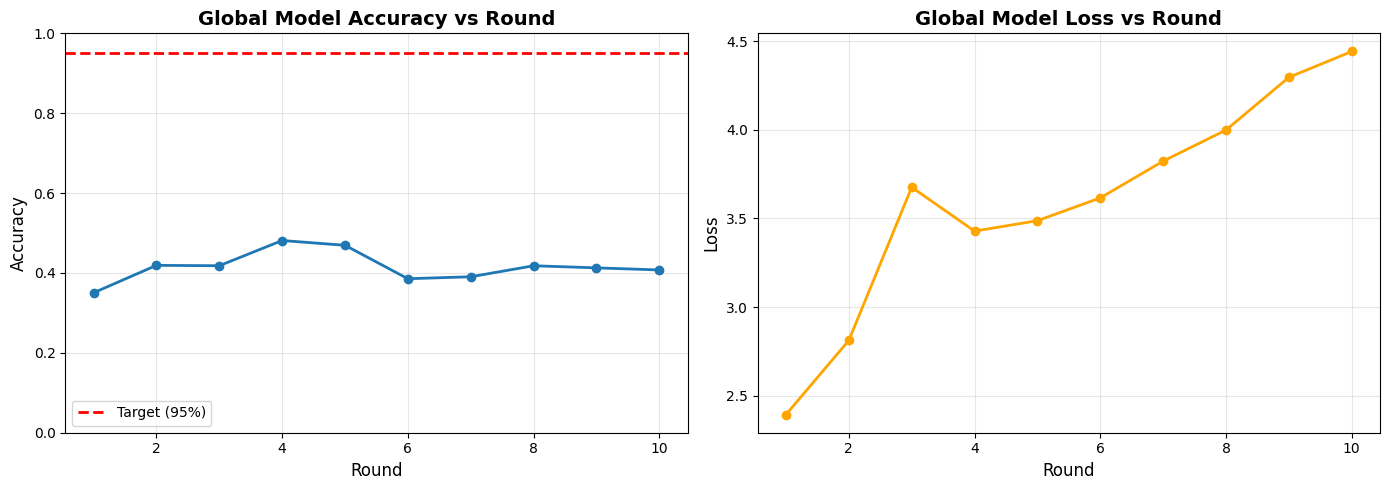


📊 Final Metrics:
   Accuracy: 0.4075 (40.75%)
   Loss: 4.4432

⚠️  Target accuracy (>95%) not yet achieved.
   Consider increasing num_rounds or tuning hyperparameters.


In [7]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(training_history['round'], training_history['accuracy'], 
            marker='o', linewidth=2, markersize=6)
axes[0].set_title('Global Model Accuracy vs Round', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Round', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Add horizontal line at 95% target
axes[0].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='Target (95%)')
axes[0].legend()

# Plot loss
axes[1].plot(training_history['round'], training_history['loss'], 
            marker='o', linewidth=2, markersize=6, color='orange')
axes[1].set_title('Global Model Loss vs Round', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Round', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_accuracy = training_history['accuracy'][-1]
final_loss = training_history['loss'][-1]

print(f"\n📊 Final Metrics:")
print(f"   Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"   Loss: {final_loss:.4f}")

if final_accuracy >= 0.95:
    print(f"\n✅ Target accuracy (>95%) achieved!")
else:
    print(f"\n⚠️  Target accuracy (>95%) not yet achieved.")
    print(f"   Consider increasing num_rounds or tuning hyperparameters.")

## 8. Save Trained Model

In [8]:
# Save global model
output_models_dir = '../Output/models'
os.makedirs(output_models_dir, exist_ok=True)

model_path = os.path.join(output_models_dir, config['paths']['global_model'])
server.save_model(model_path)

# Verify saved model
model_size = os.path.getsize(model_path) / 1024**2  # MB
print(f"\n✅ Model saved successfully!")
print(f"   Path: {model_path}")
print(f"   Size: {model_size:.2f} MB")

   💾 Global model saved to: ../Output/models/global_model.h5

✅ Model saved successfully!
   Path: ../Output/models/global_model.h5
   Size: 0.09 MB


## 9. Save Training History

In [9]:
# Prepare training history for saving
history_to_save = {
    'config': {
        'num_clients': config['num_clients'],
        'num_rounds': config['num_rounds'],
        'local_epochs': config['local_epochs'],
        'batch_size': config['batch_size'],
        'learning_rate': config['optimizer']['learning_rate'],
        'model_architecture': config['model']['hidden_layers']
    },
    'training_info': {
        'start_time': start_time.strftime('%Y-%m-%d %H:%M:%S'),
        'end_time': end_time.strftime('%Y-%m-%d %H:%M:%S'),
        'duration_seconds': training_duration.total_seconds(),
        'gpu_used': len(gpus) > 0
    },
    'history': {
        'round': training_history['round'],
        'loss': [float(x) for x in training_history['loss']],  # Convert to float for JSON
        'accuracy': [float(x) for x in training_history['accuracy']]
    },
    'final_metrics': {
        'accuracy': float(final_accuracy),
        'loss': float(final_loss)
    }
}

# Save to JSON
output_metrics_dir = '../Output/metrics'
os.makedirs(output_metrics_dir, exist_ok=True)

history_path = os.path.join(output_metrics_dir, config['paths']['training_history'])
with open(history_path, 'w') as f:
    json.dump(history_to_save, f, indent=2)

print(f"💾 Training history saved to: {history_path}")

💾 Training history saved to: ../Output/metrics/training_history.json


## 10. Quick Evaluation on Test Set

In [10]:
# Load the saved model and evaluate
print("🔍 Loading saved model for verification...")
loaded_model = model_utils.load_model(model_path)

# Evaluate on test set
print("\n📊 Evaluating on test set...")
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)

print(f"\n✅ Test Set Results:")
print(f"   Loss: {test_loss:.4f}")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate predictions for a few samples
print(f"\n🔮 Sample predictions (first 10 test samples):")
sample_predictions = loaded_model.predict(X_test[:10], verbose=0)
predicted_classes = np.argmax(sample_predictions, axis=1)
true_classes = y_test[:10]

for i in range(10):
    match = "✓" if predicted_classes[i] == true_classes[i] else "✗"
    print(f"   {match} Sample {i+1}: Predicted={predicted_classes[i]}, True={true_classes[i]}")

🔍 Loading saved model for verification...

📂 Loading model from: ../Output/models/global_model.h5
   ✓ Model loaded successfully

📊 Evaluating on test set...

✅ Test Set Results:
   Loss: 4.4432
   Accuracy: 0.4075 (40.75%)

🔮 Sample predictions (first 10 test samples):
   ✗ Sample 1: Predicted=20, True=13
   ✓ Sample 2: Predicted=6, True=6
   ✗ Sample 3: Predicted=20, True=12
   ✓ Sample 4: Predicted=20, True=20
   ✗ Sample 5: Predicted=6, True=21
   ✗ Sample 6: Predicted=20, True=10
   ✗ Sample 7: Predicted=20, True=12
   ✗ Sample 8: Predicted=20, True=7
   ✗ Sample 9: Predicted=20, True=13
   ✓ Sample 10: Predicted=8, True=8


## 11. Summary

In [11]:
print("="*80)
print("FEDERATED LEARNING TRAINING SUMMARY")
print("="*80)

print(f"\n🔧 Training Configuration:")
print(f"   Clients: {config['num_clients']}")
print(f"   Rounds: {config['num_rounds']}")
print(f"   Local epochs: {config['local_epochs']}")
print(f"   Batch size: {config['batch_size']}")
print(f"   Learning rate: {config['optimizer']['learning_rate']}")

print(f"\n⏱️  Training Time:")
print(f"   Duration: {training_duration}")
print(f"   ({training_duration.total_seconds() / 60:.2f} minutes)")
print(f"   ({training_duration.total_seconds() / 3600:.2f} hours)")

print(f"\n📊 Final Results:")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Test Loss: {test_loss:.4f}")

if test_accuracy >= 0.95:
    print(f"\n✅ SUCCESS: Target accuracy (>95%) achieved!")
else:
    print(f"\n⚠️  Target accuracy (>95%) not achieved.")
    print(f"   Gap: {(0.95 - test_accuracy)*100:.2f}%")
    print(f"\n💡 Suggestions:")
    print(f"   - Increase num_rounds to 50")
    print(f"   - Reduce learning_rate to 0.0005")
    print(f"   - Increase local_epochs to 7")

print(f"\n💾 Output Files:")
print(f"   Model: {model_path}")
print(f"   History: {history_path}")

print(f"\n📝 Next step: Run 3_Model_Evaluation_Export.ipynb")
print(f"   for detailed metrics and visualizations.")
print("="*80)

FEDERATED LEARNING TRAINING SUMMARY

🔧 Training Configuration:
   Clients: 5
   Rounds: 10
   Local epochs: 5
   Batch size: 256
   Learning rate: 0.001

⏱️  Training Time:
   Duration: 0:19:49.454801
   (19.82 minutes)
   (0.33 hours)

📊 Final Results:
   Test Accuracy: 40.75%
   Test Loss: 4.4432

⚠️  Target accuracy (>95%) not achieved.
   Gap: 54.25%

💡 Suggestions:
   - Increase num_rounds to 50
   - Reduce learning_rate to 0.0005
   - Increase local_epochs to 7

💾 Output Files:
   Model: ../Output/models/global_model.h5
   History: ../Output/metrics/training_history.json

📝 Next step: Run 3_Model_Evaluation_Export.ipynb
   for detailed metrics and visualizations.
